<a href="https://colab.research.google.com/github/FarizKesten/ChallengeAccepted/blob/main/IntrusionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks:
1. Training: Build a detection model that can detect footsteps and fence climbing given the provided data.
2. Inference: Implement a prototype that can read DAS data, run the detection model and output when
and where in the provided data footsteps resp. fence climbing occurs.
3. Visualize the output of the prototype in some way and evaluate the real-time capability of the prototype.
4. Given a few samples from a different installation, evaluate and (if necessary) adjust such that the
detection still works.

In [4]:
# Adding neccesary libraries
#!pip install -q segmentation-models-pytorch
#import segmentation_models_pytorch as smp

import os
import glob
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler


import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
'''
PATH-ACCESS

For convenience I saved all the data from the E-Mail to my Drive,
however I keep it public so that no one from outside could retrieve it. I can give acces to the Drive if neccessary
Otherwise, pleas replace the location of the data to run the script
'''

base_path = '/content/drive/MyDrive/ds_challenge'
path_task1 = os.path.join(base_path, 'Task1')
path_task2 = os.path.join(base_path, 'Task2')
path_task4 = os.path.join(base_path, 'Task4')



# Viewing sample images to get better understanding

Viewing the 3 classes as well as inference to understand the current dataset

int16 2


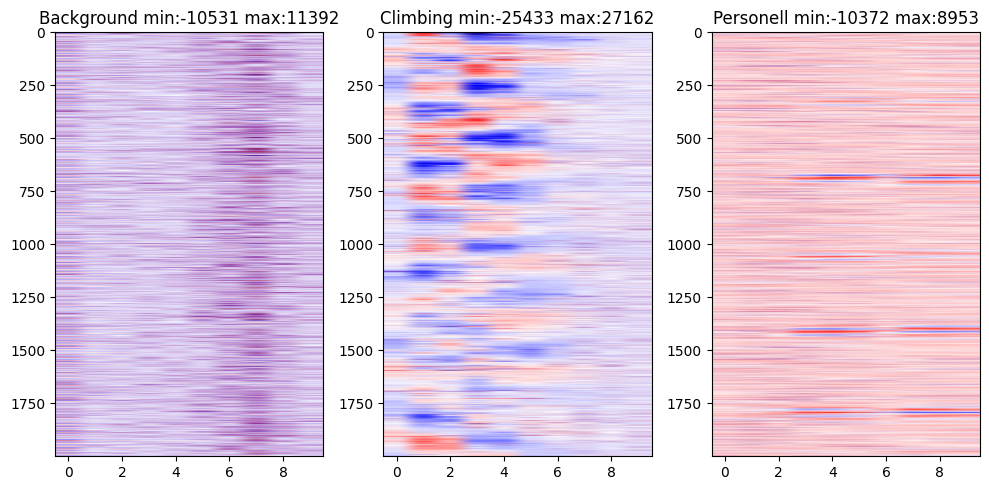

In [6]:
# find all training images

task = path_task1
#task = path_task4

# background
bgd_img = glob.glob(
    os.path.join(task, 'training', 'background', '**', '*.npy'),
    recursive=True
)

# climbing images
clm_img = glob.glob(
    os.path.join(task, 'training', 'climbing', '**', '*.npy'),
    recursive=True
)

# personnel
prs_img = glob.glob(
    os.path.join(task, 'training', 'personnel', '**', '*.npy'),
    recursive=True
)



# try to view 1 image of each class
idx = random.randint(0, min(len(bgd_img) - 1, len(clm_img) - 1, len(prs_img) - 1))
bgd = np.load(bgd_img[idx])
clm = np.load(clm_img[idx])
prs = np.load(prs_img[idx])

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

cmap = 'seismic'
axes[0].imshow(bgd, cmap=cmap, aspect="auto" )
print(bgd.dtype, bgd.ndim)
axes[0].set_title(f"Background min:{np.min(bgd)} max:{np.max(bgd)}")
#axes[0].axis('off')

axes[1].imshow(clm, cmap=cmap, aspect="auto")
axes[1].set_title(f"Climbing min:{np.min(clm)} max:{np.max(clm)}")
#axes[1].axis('off')

axes[2].imshow(prs, cmap=cmap, aspect="auto")
axes[2].set_title(f"Personell min:{np.min(prs)} max:{np.max(prs)}")
#axes[2].axis('off')

plt.tight_layout()
plt.show()



<ipython-input-7-0813a8303d27>:10: RuntimeWarning: overflow encountered in scalar subtract
  normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))


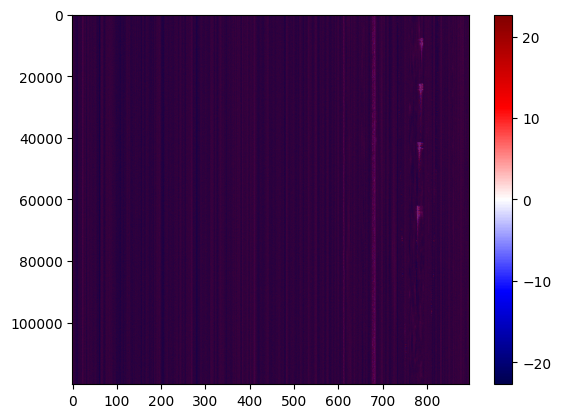

In [7]:
# view inference image

# inference
inf_img = glob.glob(
    os.path.join(path_task2, 'inference', '*.npy'),
    recursive=True
)

image = np.load(inf_img[0])
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
plt.imshow(normalized_image, cmap="seismic", aspect="auto")
plt.colorbar()
plt.show()


# Task 1 : Training

I see this as a segmentation task since we also need to localize the class in the image.

For rapid-prototyping of segmentation models I would use the segmentaiton-models-pytorch library

In [8]:
# install segmentation-models library
import importlib.util

if importlib.util.find_spec('segmentation_models_pytorch') is None:
    !pip install -q segmentation-models-pytorch > /dev/null 2>&1

import segmentation_models_pytorch as smp


In [9]:
# CONSTANTS

BATCH_SIZE = 4
CLASS_ID = { "background" : 0, "climbing" : 1, "personnel" : 2}


### Preparing Dataset Pipeline


In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random
import torch.nn as nn

class SegmentationDataset(Dataset):
  """
  Setting up datasets for training, validation and testing
  """
  def __init__(self, image_path, class_id, transform=False):
    self.transform = transform
    self.class_id = class_id

    self.image_path = image_path

  def __len__(self):
    return len(self.image_path)


  def trans(self, image, mask):
    '''
    add some randomness on the training dataset
    '''

    if random.random() > 0.5:
      image = F.hflip(image)
      label = F.hflip(mask)

    if random.random() > 0.5:
      image = F.vflip(image)
      label = F.vflip(mask)

    if random.random() > 0.5:
      angle = random.randint(-30, 30)
      image = F.rotate(image, angle)
      label = F.rotate(mask, angle)

    return image, mask


  def __getitem__(self, index):
    '''
    get both images and create a mask filled with the class_id.
    Assumption: each image has a corresponding mask without
    background information
    '''

    image = np.load(self.image_path[index])

    #print(f"Now Loaded Image Shape: {image.shape}, dtype: {image.dtype}")

    height, width = image.shape

    #print(f"Before np full {height} {width}")
    mask  = np.full((height, width), fill_value=self.class_id[index], dtype=np.int32)

    #print(f"Created Mask Shape: {mask.shape}, dtype: {mask.dtype}")
    image_tensor = torch.from_numpy(image).unsqueeze(0)
    mask_tensor = torch.from_numpy(mask)


    if self.transform:
      image_pil = F.to_pil_image(image_tensor)
      mask_pil = F.to_pil_image(mask_tensor)
      image_pil, mask_pil  = self.trans(image_pil, mask_pil)

    #print("After transform")
    # convert back to tensors
    image_tensor = T.ToTensor()(image_pil)
    mask_tensor = torch.from_numpy(np.array(mask_pil, dtype=np.int32)).long()

    # Determine padding needed (to make height & width divisible by 32)
    #(needed for example by U-Net)
    pad_h = (32 - height % 32) if height % 32 != 0 else 0
    pad_w = (32 - width % 32) if width % 32 != 0 else 0

    # Apply padding (PyTorch uses (left, right, top, bottom) format)
    #image_tensor = F.pad(image_tensor, (0, pad_w, 0, pad_h), value=0)  # Pad right & bottom
    #mask_tensor = F.pad(mask_tensor, (0, pad_w, 0, pad_h), value=0)  # Pad right & bottom
    #image_tensor = F.pad(image_tensor, (0, pad_w, 0, pad_h), mode='constant', value=0)
    #mask_tensor = F.pad(mask_tensor, (0, pad_w, 0, pad_h), mode='constant', value=0)
    padder = nn.ConstantPad2d((0, pad_w, 0, pad_h), 0)
    image_tensor = padder(image_tensor)
    mask_tensor = padder(mask_tensor)



    #print(f"Final Image Tensor Shape: {image_tensor.shape}, dtype: {image_tensor.dtype}")
    #print(f"Final Mask Tensor Shape: {mask_tensor.shape}, dtype: {mask_tensor.dtype}")

    return image_tensor.float(), mask_tensor.long()


def gather_class_paths(task_dir, split="training", class_name="background", class_id=0):
    """
    :param task_dir:   The base directory that contains your 'training', 'validation', etc. folders
    :param split:      One of {'training', 'validation', 'test'} or similar subdirectory
    :param class_name: The subfolder name for the class (e.g. 'background', 'climbing', etc.)
    :param class_id:   Numeric label to assign to all found images
    """

    search_pattern = os.path.join(task_dir, split, class_name, '**', '*.npy')
    image_paths = glob.glob(search_pattern, recursive=True)

    class_ids = [class_id] * len(image_paths)

    return image_paths, class_ids


# collect all training data
bg_path, bg_id = gather_class_paths(task_dir=path_task1, split="training", class_name="background", class_id=CLASS_ID["background"])
prs_path, prs_id = gather_class_paths(task_dir=path_task1, split="training", class_name="personnel", class_id=CLASS_ID["personnel"])
clm_path, clm_id = gather_class_paths(task_dir=path_task1, split="training", class_name="climbing", class_id=CLASS_ID["climbing"])

all_training_path = bg_path + prs_path + clm_path
all_training_id = bg_id + prs_id + clm_id

train_dataset = SegmentationDataset(
    image_path=all_training_path,
    class_id=all_training_id,
    transform=True
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


# collect all validation & test data (30% goes to test dataset)
bg_path, bg_id = gather_class_paths(task_dir=path_task1, split="validation", class_name="background", class_id=CLASS_ID["background"])
prs_path, prs_id = gather_class_paths(task_dir=path_task1, split="validation", class_name="personnel", class_id=CLASS_ID["personnel"])
clm_path, clm_id = gather_class_paths(task_dir=path_task1, split="validation", class_name="climbing", class_id=CLASS_ID["climbing"])

all_paths = bg_path + prs_path + clm_path
all_ids = bg_id + prs_id + clm_id

val_paths, test_paths, val_ids, test_ids = train_test_split(
    all_paths, all_ids, test_size=0.3, random_state=42, stratify=all_ids
)


val_dataset = SegmentationDataset(
    image_path=val_paths,
    class_id=val_ids,
    transform=True
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SegmentationDataset(
    image_path=test_paths,
    class_id=test_ids,
    transform=True
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


print(f"Number of training dataset: {len(train_dataset)}")
print(f"Number of validation dataset: {len(val_dataset)}")
print(f"Number of test dataset: {len(test_dataset)}")


Number of training dataset: 2699
Number of validation dataset: 1238
Number of test dataset: 531


### Choosing the Model for classification

Potentially multiple models can be use to train and test for its performance

In [11]:
# try out multiple model candidates
encoder_name = "resnet34"
encoder_weights = "imagenet"
in_channels=1
classes=3

models = {
    # Klassiker
    "Unet": smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes
    ),

    # included dense skip connections
    "Unet++": smp.UnetPlusPlus(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes
    ),

    # Lightweight and Fast
    "FPN": smp.FPN(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes
    ),

    "PAN": smp.PAN(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes
    ),

}


models = {
    # Klassiker
    "Unet": smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes
    ),
}

# printing all models that are used
print("models under tests:")
for key, model in models.items():
  print(key)

models under tests:
Unet


### add some training functions


In [12]:
# Training funcs

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
      images = images.to(device)
      masks = masks.to(device)
      print(images.shape)
      print(masks.shape)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, masks)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    return running_loss / len(loader)


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
      for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        running_loss += loss.item()

    return running_loss / len(loader)


def eval_multi_class(pred, target, num_classes, threshold=0.5):

    # Convert logits to predicted class indices
    pred = torch.argmax(pred, dim=1)

    iou_per_class = []
    precision_per_class = []
    recall_per_class = []

    for class_idx in range(num_classes):
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()

        intersection = (pred_class * target_class).sum().item()
        union = (pred_class + target_class).sum().item() - intersection

        # Compute IOU, avoid division by zero
        iou = intersection / (union + 1e-6)
        iou_per_class.append(iou)

        # Compute Precision & Recall
        tp = intersection
        fp = pred_class.sum().item() - tp
        fn = target_class.sum().item() - tp

        precision = (tp + 1e-6) / (tp + fp + 1e-6)
        recall = (tp + 1e-6) / (tp + fn + 1e-6)

        precision_per_class.append(precision)
        recall_per_class.append(recall)

    return {
        "IOU": sum(iou_per_class) / num_classes,
        "Precision": sum(precision_per_class) / num_classes,
        "Recall": sum(recall_per_class) / num_classes,
        "Class-wise IOU": iou_per_class,
        "Class-wise Precision": precision_per_class,
        "Class-wise Recall": recall_per_class
    }

### Finally start training

In [ ]:
# Start Training

NUM_EPOCHS = 10

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use CrossEntropyLoss for multi-class classification
criterion = torch.nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for key, model in models.items():
    best_val_loss = float('inf')

    # Define model saving directory
    model_dir = os.path.join(path_task1, "models", key)
    os.makedirs(model_dir, exist_ok=True)

    # Move model to GPU/CPU
    model.to(device)

    for epoch in range(NUM_EPOCHS):
        # Train and evaluate the model
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate(model, val_loader, criterion, device)

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))
            print(f"New best model {key} saved at epoch {epoch+1}, Val Loss: {val_loss:.4f}")


        print(f"📢 Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size([4, 1, 2016, 32])
torch.Size([4, 2016, 32])
torch.Size